In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_112932/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import shutil

import numpy as np
import time
from pyDOE import lhs
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
import argparse
class Options_PoissonHD:
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--cuda', default=True, help='if you use cuda')
        
        parser.add_argument('--bot_top', type=tuple, default=(-1, 1), help='a tuple of the form (bot, top)')
        parser.add_argument('--dim', default=50, help='dimension')
        parser.add_argument('--N_r', default=2400, help='num of interior points')
        parser.add_argument('--N_b', default=1200, help='num of boundary points')
        
        parser.add_argument('--backbone_layers', type=list, default=([60]*5), help='list of nn layers of backbone')
        parser.add_argument('--subnet_layers', type=list, default=([80]*4), help='list of nn layers of subnet')
        
        parser.add_argument('--backbone_lr', type=float, default=1e-3, help='initial learning rate of backbone')
        parser.add_argument('--subnet_lr', type=float, default=1e-4, help='initial learning rate of subnet')
        
        parser.add_argument('--gamma', type=float, default=0.95, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step_size of lr_scheduler for Adam optimizer')
        
        parser.add_argument('--iters_stage1', type=int, default=1, help='iters for stage 1 used Adam')
        parser.add_argument('--iters_stage2', type=int, default=0, help='iters for stage 2 used Adam')
        parser.add_argument('--iters_stage3', type=int, default=40000, help='iters for stage 3 used Adam')
        parser.add_argument('--iters_stage4', type=int, default=0, help='iters for stage 4 used Adam')
        
        parser.add_argument('--lam_res', type=float, default=1, help='weight of loss_res')
        parser.add_argument('--lam_bcs', type=float, default=1, help='weight of loss_bcs')
        parser.add_argument('--K1', type=int, default=50, help='for stage3, optimize the backbone K1 times every (K1+K2) iters')
        parser.add_argument('--K2', type=int, default=50, help='for stage3, optimize the transformer K2 times every (K1+K2) iters')
        parser.add_argument('--k_scale', type=float, default=0.1, help='the scale of transformer limited residue')
        
        self.parser = parser

    def parse_default(self):
        args = self.parser.parse_args(args=[])
        args.device = torch.device('cuda' if args.cuda else 'cpu')
        
        # 增加网络输入输出层
        args.backbone_layers = [args.dim] + args.backbone_layers + [1]
        args.subnet_layers = [args.dim] + args.subnet_layers + [args.dim]
        return args
    

args = Options_PoissonHD().parse_default()
print(args.cuda)

True


In [4]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth')
        shutil.copyfile(last_model, best_model)

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [5]:
seed_torch(42)

## 网络模型 (Modified ResNet / ResNet / Modified MLP / MLP)

In [6]:
class ModifiedResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedResNet, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X + X_
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [7]:
class ResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ResNet, self).__init__()
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X_ + X
        return self.model[-1](X)

In [8]:
class ModifiedMLP(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedMLP, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        for i in range(len(self.model) - 1):
            X = self.model[i](X)
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [9]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)


In [10]:
backbone = ResNet(args.backbone_layers)
backbone = backbone.to(args.device)
args.backbone = backbone
print(args.backbone)

ResNet(
  (model): Sequential(
    (first): Sequential(
      (fc0): Linear(in_features=50, out_features=60, bias=True)
      (act0): Tanh()
    )
    (block1): Sequential(
      (fc1_0): Linear(in_features=60, out_features=60, bias=True)
      (act1_0): Tanh()
      (fc1_1): Linear(in_features=60, out_features=60, bias=True)
      (act1_1): Tanh()
    )
    (block2): Sequential(
      (fc2_0): Linear(in_features=60, out_features=60, bias=True)
      (act2_0): Tanh()
      (fc2_1): Linear(in_features=60, out_features=60, bias=True)
      (act2_1): Tanh()
    )
    (block3): Sequential(
      (fc3_0): Linear(in_features=60, out_features=60, bias=True)
      (act3_0): Tanh()
      (fc3_1): Linear(in_features=60, out_features=60, bias=True)
      (act3_1): Tanh()
    )
    (block4): Sequential(
      (fc4_0): Linear(in_features=60, out_features=60, bias=True)
      (act4_0): Tanh()
      (fc4_1): Linear(in_features=60, out_features=60, bias=True)
      (act4_1): Tanh()
    )
    (last): S

## 对抗TransformerNet

In [11]:
class TransformerNet(nn.Module):
    def __init__(self, model, bot_top):
        super(TransformerNet, self).__init__()
        self.model = model
        bot, top = bot_top
        self.length = top - bot
        self.mid = (bot + top) / 2
        
    def input_transform(self, X):
        """输入变换 压缩到[-1,1]再传入arcsin"""
        return torch.arcsin((X - self.mid) / self.length * 2.) / torch.pi
    
    def output_transform(self, X):
        # to PDE's domain 非线性放缩
        return torch.sin(torch.pi * X) / 2. * self.length + self.mid
    
    def forward(self, X, residual_limit):
        X = self.input_transform(X)
        X_ = self.model(X)
        
        X_ = torch.tanh(X_) * residual_limit  # 限制变换残差的界
        
        X = self.output_transform(X + X_)
        return X
    

model = MLP(args.subnet_layers)
transformer = TransformerNet(model, args.bot_top)
transformer = transformer.to(args.device)
args.transformer = transformer
print(args.transformer)

TransformerNet(
  (model): MLP(
    (model): Sequential(
      (layer0): Sequential(
        (fc0): Linear(in_features=50, out_features=80, bias=True)
        (act0): Tanh()
      )
      (layer1): Sequential(
        (fc1): Linear(in_features=80, out_features=80, bias=True)
        (act1): Tanh()
      )
      (layer2): Sequential(
        (fc2): Linear(in_features=80, out_features=80, bias=True)
        (act2): Tanh()
      )
      (layer3): Sequential(
        (fc3): Linear(in_features=80, out_features=80, bias=True)
        (act3): Tanh()
      )
      (layer4): Sequential(
        (fc4): Linear(in_features=80, out_features=50, bias=False)
      )
    )
  )
)


## 数据集生成

In [12]:
class Dataset_PoissonHD:
    def __init__(self, bot_top, dim, device, N_max=100000):
        """
        bot_top: 空间的上下界 默认是(-1,1)
        N_max: 原始的总样本点数 例如interior(N_r) 从N_max中随机采样N_r个点作为初始点
        """
        self.bot, self.top = bot_top
        self.dim = dim
        self.device = device
        self.N_max = N_max
    
    def train_data(self, N_r, N_b):
        """训练点采样"""
        X_res = self.interior(N_r).to(self.device)
        X_bcs = self.boundary(N_b).to(self.device)
        f_res = self.func_res(X_res).to(self.device)
        u_bcs = self.func_bcs(X_bcs).to(self.device)
        
        return X_res, X_bcs, f_res, u_bcs
    
    def interior(self, N_r):
        """内部点采样"""
        X_res = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_r]
        return X_res[idx]
    
    def boundary(self, N_b):
        """边界点采样"""
        X_bcs = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        bots = self.bot * torch.ones(1, 1)
        tops = self.top * torch.ones(1, 1)
        
        n = int(self.N_max / self.dim / 2)
        num = [n * i for i in range(2 * self.dim)]
        num[0] = 0
        num.append(self.N_max)
        
        for i in range(self.dim):  # 逐个维度设为下界bot 以及上界top 得到边界点
            X_bcs[num[2 * i]:num[2 * i + 1], i] = bots.repeat(num[2 * i + 1] - num[2 * i], 1).squeeze()
            X_bcs[num[2 * i + 1]:num[2 * i + 2], i] = tops.repeat(num[2 * i + 2] - num[2 * i + 1], 1).squeeze()

        idx = torch.randperm(self.N_max)
        idx = idx[:N_b]
        return X_bcs[idx]
    
    def func_res(self, X_res):
        """控制方程右端项"""
        f = X_res.mean(axis=1, keepdims=True)
        f = (torch.sin(f) - 2) / self.dim
        return f
    
    def func_bcs(self, X_bcs):
        """边界条件右端项"""
        u_bcs = X_bcs.mean(axis=1, keepdims=True)
        u_bcs = u_bcs ** 2 + torch.sin(u_bcs)
        return u_bcs


dataset = Dataset_PoissonHD(args.bot_top, args.dim, args.device)
args.dataset = dataset
X_res, X_bcs, f_res, u_bcs = dataset.train_data(args.N_r, args.N_b)
print(X_res.shape, X_bcs.shape, f_res.shape, u_bcs.shape)

torch.Size([2400, 50]) torch.Size([1200, 50]) torch.Size([2400, 1]) torch.Size([1200, 1])


## 训练

In [13]:
class Trainer_PoissonHD:
    def __init__(self, args):
        self.args = args
        self.dim = args.dim
        self.device = args.device
        
        self.N_r = args.N_r
        self.N_b = args.N_b
        self.dataset = args.dataset
        
        self.lam_res = args.lam_res
        self.lam_bcs = args.lam_bcs
        self.gamma = args.gamma
        self.backbone = args.backbone
        
        self.model_name = self.backbone.__class__.__name__
        self.model_path = self.get_model_path()
        
        self.iters_stage1 = args.iters_stage1
        self.iters_stage2 = args.iters_stage2
        self.iters_stage3 = args.iters_stage3
        self.iters_stage4 = args.iters_stage4
        
        self.K1 = args.K1
        self.K2 = args.K2

        # eps = np.finfo(np.float32).eps
        self.optimizer_Adam = optim.Adam(self.backbone.parameters(), lr=args.backbone_lr, betas=(0.9, 0.999))
        
        self.step_size = args.step_size#int( self.iters_stage4 / (np.log(1e-3) / np.log(self.gamma)) )
        self.scheduler = ExponentialLR(self.optimizer_Adam, gamma=self.gamma, verbose=True)
        
        # subnet (transformer net)
        self.transformer = args.transformer
        self.optimizer_Adam_transformer = optim.Adam(self.transformer.parameters(), lr=args.subnet_lr)    
        self.scheduler_transformer = ExponentialLR(self.optimizer_Adam_transformer, gamma=args.gamma, verbose=True)
        
        # data
        self.X_res, self.X_bcs, self.f_res, self.u_bcs = self.dataset.train_data(self.N_r, self.N_b)
        
        # Logger
        self.logger = {
            f"stage{i + 1}": {
                "loss": [],
                "loss_res": [],
                "loss_bcs": [],
                "iter": []
            }
            for i in range(4)
        }
        self.logger_valid = {
            f"stage{i + 1}": {
                "loss": [],
                "loss_res": [],
                "loss_bcs": [],
                "iter": [],
                "error": [],  # relative l2 error
                
                "loss_transformer": [],
                "loss_res_transformer": [],
                "loss_bcs_transformer": [],
                "error_transformer": []  # 同一批点 经过transformer变换的rl2
            }
            for i in range(4)
        }
        
        self.backbone_requires_grad = None  # 用以判断是否要更新该网络
        self.transformer_requires_grad = None
        
        self.k = None
        self.k_scale = args.k_scale
        
    def get_model_path(self):
        """生成保存模型的路径"""
        if not os.path.exists('models'):
            os.mkdir('models')
        
        path = os.path.join('models', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path
        
    def update_train_data(self, update_k=False):
        """更新采样点"""
        self.X_res, self.X_bcs, self.f_res, self.u_bcs = self.dataset.train_data(self.N_r, self.N_b)
        
        if update_k:
            self.k = self.update_k(self.X_res, self.f_res)
        
    def update_k(self, X_res, f_res):
        """将X_res输入net_r 确定这批X_res的限制残差的系数k"""
        self.backbone.train(False)
        
        f_res_pred = self.net_r(X_res)
        k = (f_res_pred - f_res) ** 2
#         k_sort = torch.sort(k.flatten(), dim=0).values
#         k_min2 = k_sort[10]  # 不取最小值 取近似近似的
#         k_max2 = k_sort[-10]
#         k = k / (k_max2 - k_min2)
        k = k / (k.max() - k.min())
        self.backbone.train()
        return k.detach_() * self.k_scale
            
    def set_backbone_requires_grad(self, bl):
        """设置backbone是否记录梯度"""
        self.backbone_requires_grad = bl
        for param in self.backbone.parameters():
            param.requires_grad = bl

    def set_transformer_requires_grad(self, bl):
        """设置transformer是否记录梯度"""
        self.transformer_requires_grad = bl
        for param in self.transformer.parameters():
            param.requires_grad = bl

    def net_u(self, X):
        return self.backbone(X)

    def net_r(self, x):
        x.requires_grad_(True)

        u = self.net_u(x)
        grad_u = grad(u, x)[0]
        u_xx = torch.zeros(u.shape).to(x.device)
        for i in range(self.dim):
            u_xx += grad(grad_u[:, [i]], x)[0][:, [i]]

        return - u_xx
    
    def net_transformer(self, X, k):
        X.requires_grad_(False)
        return self.transformer(X, k)
    
    def compute_loss(self, use_transformer=False):
        """计算loss 可选择是否使用transformer"""
        if use_transformer:
            if self.transformer_requires_grad and not self.backbone_requires_grad:
                # 只更新transformer 训练点只考虑变换后的X_res_ 用loss_res
                
                self.X_res_ = self.X_res.clone().detach()
                self.X_res_ = self.net_transformer(self.X_res_, self.k)
                # clone会新开辟一片内存 detach会从计算图剥离
                # 用X_res_.clone().detach()计算f_res
                # 可以避免X_res计算图混乱
                # 从而保证transformer的网络正常地梯度传播
                self.f_res_ = self.dataset.func_res(self.X_res_.clone().detach())  # 细节

                f_res_pred_ = self.net_r(self.X_res_)
                
                self.loss_res = torch.mean((f_res_pred_ - self.f_res_) ** 2)
                self.loss = self.lam_res * self.loss_res
                
            elif self.backbone_requires_grad and not self.transformer_requires_grad:
                # 只更新backbone 训练点考虑变换前后的X_res X_res_ X_bcs 用loss_res和loss_bcs
                
                self.X_res_ = self.X_res.clone().detach()
                self.X_res_ = self.net_transformer(self.X_res_, self.k)
                self.f_res_ = self.dataset.func_res(self.X_res_.clone().detach())  # 细节
                
                f_res_pred_ = self.net_r(self.X_res_)
                
                self.loss_res = torch.mean((f_res_pred_ - self.f_res_) ** 2)

                u_bcs_pred = self.net_u(self.X_bcs)
                self.loss_bcs = torch.mean((u_bcs_pred - self.u_bcs) ** 2)

                self.loss = self.lam_res * self.loss_res + self.lam_bcs * self.loss_bcs
            else:
                raise "error at compute_loss"
        else:
            f_res_pred = self.net_r(self.X_res)
            self.loss_res = torch.mean((f_res_pred - self.f_res) ** 2)

            u_bcs_pred = self.net_u(self.X_bcs)
            self.loss_bcs = torch.mean((u_bcs_pred - self.u_bcs) ** 2)

            self.loss = self.lam_res * self.loss_res + self.lam_bcs * self.loss_bcs


    def log_loss(self):
        """记录当前loss至logger字典"""
        self.logger[f"stage{self.current_stage}"]["loss"].append(self.loss.item())
        self.logger[f"stage{self.current_stage}"]["loss_res"].append(self.loss_res.item())
        self.logger[f"stage{self.current_stage}"]["loss_bcs"].append(self.loss_bcs.item())
        self.logger[f"stage{self.current_stage}"]["iter"].append(self.iter + 1)

    def log_info(self):
        """保存并打印训练信息"""
        info = f'Stage {self.current_stage} Iter {self.iter+1:5d} Time:{time.time()-self.start_time:.1e} # ' + \
               f'Loss:{self.loss.item():.2e}, Loss_r:{self.loss_res.item():.2e}, Loss_b:{self.loss_bcs.item():.2e} # ' + \
               f'Valid:{self.valid_loss_value:.2e}, RL2:{self.error_u:.2e}'
        with open("train_info.txt", 'a') as f:
            f.write(info + '\n')
        print(info)
        
    def compute_rl2(self, X_res):
        """计算relative l2 error"""
        u_star = X_res.mean(axis=1, keepdims=True)
        u_star = u_star**2 + torch.sin(u_star)
        u_star = u_star.detach().cpu().numpy()
        
        u_pred = self.net_u(X_res)  # 计算预测解
        u_pred = u_pred.detach().cpu().numpy()
        
        error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)  # rl2 error
        return error_u

    def valid(self):
        """验证并保存最优模型"""
        # 计算loss
        X_res, X_bcs, f_res, u_bcs = self.dataset.train_data(1000, 1000)
        k = self.update_k(X_res, f_res)
        
        self.backbone.eval()
        self.transformer.eval()
        # 不经过transformer的loss
        f_res_pred = self.net_r(X_res)
        u_bcs_pred = self.net_u(X_bcs)
        loss_res = torch.mean((f_res_pred - f_res) ** 2)
        loss_bcs = torch.mean((u_bcs_pred - u_bcs) ** 2)
        loss = self.lam_res * loss_res + self.lam_bcs * loss_bcs
        
        # 经过transformer后的内部点的loss
        X_res_ = self.net_transformer(X_res, k)
        f_res_ = self.dataset.func_res(X_res_.clone().detach())  # 计算相应X_res_的新的f_res_
        f_res_pred_transformer = self.net_r(X_res_)
        u_bcs_pred_transformer = self.net_u(X_bcs)  # 边界点也计算 对比经过和不经过transformer的两次loss 确保两次loss是基于同一批训练点
        loss_res_transformer = torch.mean((f_res_pred_transformer - f_res_) ** 2)
        loss_bcs_transformer = torch.mean((u_bcs_pred_transformer - u_bcs) ** 2)
        loss_transformer = self.lam_res * loss_res_transformer + self.lam_bcs * loss_bcs_transformer
        
        # 计算relative l2 error
        self.error_u = self.compute_rl2(X_res)
        self.error_u_transformer = self.compute_rl2(X_res_)  # 经过transformer变换的内部点 看看其rl2是否会更大 即更难学
        
        self.backbone.train()
        self.transformer.train()
        
        # 记录valid的loss和rl2 error信息
        self.logger_valid[f"stage{self.current_stage}"]["loss"].append(loss.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_res"].append(loss_res.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_bcs"].append(loss_bcs.item())
        self.logger_valid[f"stage{self.current_stage}"]["iter"].append(self.iter + 1)
        self.logger_valid[f"stage{self.current_stage}"]["error"].append(self.error_u)
        
        self.logger_valid[f"stage{self.current_stage}"]["loss_transformer"].append(loss_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_res_transformer"].append(loss_res_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_bcs_transformer"].append(loss_bcs_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["error_transformer"].append(self.error_u_transformer)
        
        # 验证模型loss是否最优并选择保存
        self.valid_loss_value = loss.item()
        is_best = self.valid_loss_value < self.best_loss
        if is_best:
            self.best_loss = self.valid_loss_value
        state = {
            'stage': self.current_stage,
            'iter': self.iter,
            'state_dict': self.backbone.state_dict(),
            'state_dict_transformer': self.transformer.state_dict(),
            'best_loss': self.best_loss
        }
        save_model(state, is_best, save_dir=self.model_path)
    
    def train(self):
        """DAR 4个Stage 训练"""
        self.start_time = time.time()
        self.best_loss = 1.e10
        
        # stage1 只训练backbone
        self.iter = 0
        self.current_stage = 1  # 设置当前stage
        self.set_backbone_requires_grad(True)  # 记录backbone的梯度
        self.set_transformer_requires_grad(False)  # 不记录transformer的梯度
        for _ in range(self.iters_stage1):
            self.optimizer_Adam.zero_grad()
            self.compute_loss(use_transformer=False)
            self.loss.backward()
            self.optimizer_Adam.step()
            self.log_loss()        
            
            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data()
            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
            self.iter += 1
            
            
        self.k = self.update_k(self.X_res, self.f_res)
            
                
        # stage2 只训练transformer
        self.iter = 0
        self.current_stage = 2
        self.set_backbone_requires_grad(False)
        self.set_transformer_requires_grad(True)
        for _ in range(self.iters_stage2):       
            self.optimizer_Adam_transformer.zero_grad()
            self.compute_loss(use_transformer=True)
            self.loss.backward()

            for param in self.transformer.parameters():
                if param.requires_grad == True:
                    param.grad *= -1
            self.optimizer_Adam_transformer.step()

            self.log_loss()
            
            if (self.iter + 1) % 10 == 0:
                self.valid()
                self.log_info()
                self.update_train_data(update_k=True)
            if (self.iter + 1) % self.step_size == 0:
                self.scheduler_transformer.step()
            self.iter += 1

        # stage3 同时训练backbone和transformer
        self.iter = 0
        self.current_stage = 3
        self.set_backbone_requires_grad(True)
        self.set_transformer_requires_grad(True)
        for _ in range(self.iters_stage3):
            self.optimizer_Adam.zero_grad()
            self.optimizer_Adam_transformer.zero_grad()
            
            # 优化K1次backbone 再优化K2次transformer 如此往复
            if (self.iter % (self.K1 + self.K2)) < self.K1:
                # 使用transformer优化backbone
                self.set_backbone_requires_grad(True)
                self.set_transformer_requires_grad(False)
                self.compute_loss(use_transformer=True)
                self.loss.backward()
                self.optimizer_Adam.step()
            else:
                # 优化transformer
                self.set_backbone_requires_grad(False)
                self.set_transformer_requires_grad(True)
                self.compute_loss(use_transformer=True)
                self.loss.backward()

                for param in self.transformer.parameters():
                    if param.requires_grad == True:
                        param.grad *= -1
                self.optimizer_Adam_transformer.step()
            
            self.log_loss()

            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data(update_k=True)
                
            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
                self.scheduler_transformer.step()
            self.iter += 1
            
        # stage4 只训练backbone
        self.iter = 0
        self.current_stage = 4
        self.set_backbone_requires_grad(True)
        self.set_transformer_requires_grad(False)
        for _ in range(self.iters_stage4):
            self.optimizer_Adam.zero_grad()
            self.compute_loss(use_transformer=False)
            self.loss.backward()
            self.optimizer_Adam.step()
            self.log_loss()

            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data()

            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
            self.iter += 1
            
            
trainer = Trainer_PoissonHD(args)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-04.


In [14]:
trainer.train()

Stage 3 Iter   100 Time:9.1e+00 # Loss:2.61e-04, Loss_r:2.61e-04, Loss_b:1.78e-04 # Valid:4.23e-04, RL2:1.68e-01
Stage 3 Iter   200 Time:2.8e+01 # Loss:1.26e-04, Loss_r:1.26e-04, Loss_b:9.28e-05 # Valid:2.41e-04, RL2:1.25e-01
Stage 3 Iter   300 Time:4.9e+01 # Loss:1.07e-04, Loss_r:1.07e-04, Loss_b:9.59e-05 # Valid:2.10e-04, RL2:1.15e-01
Stage 3 Iter   400 Time:7.0e+01 # Loss:7.00e-05, Loss_r:7.00e-05, Loss_b:7.54e-05 # Valid:1.47e-04, RL2:1.11e-01
Stage 3 Iter   500 Time:9.1e+01 # Loss:6.14e-05, Loss_r:6.14e-05, Loss_b:7.26e-05 # Valid:1.50e-04, RL2:1.08e-01
Stage 3 Iter   600 Time:1.1e+02 # Loss:5.38e-05, Loss_r:5.38e-05, Loss_b:6.79e-05 # Valid:1.29e-04, RL2:1.08e-01
Stage 3 Iter   700 Time:1.3e+02 # Loss:4.35e-05, Loss_r:4.35e-05, Loss_b:9.07e-05 # Valid:1.44e-04, RL2:1.09e-01
Stage 3 Iter   800 Time:1.5e+02 # Loss:3.63e-05, Loss_r:3.63e-05, Loss_b:6.06e-05 # Valid:1.24e-04, RL2:9.56e-02
Stage 3 Iter   900 Time:1.7e+02 # Loss:3.07e-05, Loss_r:3.07e-05, Loss_b:4.46e-05 # Valid:9.71e-

Stage 3 Iter  7100 Time:1.4e+03 # Loss:1.28e-06, Loss_r:1.28e-06, Loss_b:5.76e-07 # Valid:2.03e-06, RL2:1.25e-02
Stage 3 Iter  7200 Time:1.5e+03 # Loss:1.19e-06, Loss_r:1.19e-06, Loss_b:5.87e-07 # Valid:1.83e-06, RL2:9.54e-03
Stage 3 Iter  7300 Time:1.5e+03 # Loss:1.09e-06, Loss_r:1.09e-06, Loss_b:5.09e-07 # Valid:1.90e-06, RL2:1.06e-02
Stage 3 Iter  7400 Time:1.5e+03 # Loss:1.14e-06, Loss_r:1.14e-06, Loss_b:5.96e-07 # Valid:3.02e-06, RL2:1.65e-02
Stage 3 Iter  7500 Time:1.5e+03 # Loss:1.30e-06, Loss_r:1.30e-06, Loss_b:8.93e-07 # Valid:1.92e-06, RL2:1.04e-02
Stage 3 Iter  7600 Time:1.5e+03 # Loss:9.50e-07, Loss_r:9.50e-07, Loss_b:4.59e-07 # Valid:1.94e-06, RL2:8.83e-03
Stage 3 Iter  7700 Time:1.6e+03 # Loss:2.20e-06, Loss_r:2.20e-06, Loss_b:3.98e-05 # Valid:3.82e-05, RL2:7.38e-02
Stage 3 Iter  7800 Time:1.6e+03 # Loss:9.71e-07, Loss_r:9.71e-07, Loss_b:5.29e-07 # Valid:1.55e-06, RL2:9.06e-03
Stage 3 Iter  7900 Time:1.6e+03 # Loss:1.09e-06, Loss_r:1.09e-06, Loss_b:5.40e-07 # Valid:1.72e-

Stage 3 Iter 14100 Time:2.9e+03 # Loss:2.47e-07, Loss_r:2.47e-07, Loss_b:1.82e-07 # Valid:4.87e-07, RL2:5.37e-03
Stage 3 Iter 14200 Time:2.9e+03 # Loss:2.54e-07, Loss_r:2.54e-07, Loss_b:1.60e-07 # Valid:6.33e-07, RL2:5.42e-03
Stage 3 Iter 14300 Time:2.9e+03 # Loss:4.10e-07, Loss_r:4.10e-07, Loss_b:4.69e-06 # Valid:5.26e-06, RL2:2.71e-02
Stage 3 Iter 14400 Time:2.9e+03 # Loss:2.43e-07, Loss_r:2.43e-07, Loss_b:1.85e-07 # Valid:5.24e-07, RL2:5.53e-03
Stage 3 Iter 14500 Time:3.0e+03 # Loss:2.76e-07, Loss_r:2.76e-07, Loss_b:1.82e-07 # Valid:6.18e-07, RL2:4.63e-03
Stage 3 Iter 14600 Time:3.0e+03 # Loss:3.32e-07, Loss_r:3.32e-07, Loss_b:7.88e-07 # Valid:7.44e-07, RL2:6.41e-03
Stage 3 Iter 14700 Time:3.0e+03 # Loss:2.37e-07, Loss_r:2.37e-07, Loss_b:1.25e-07 # Valid:4.63e-07, RL2:5.41e-03
Stage 3 Iter 14800 Time:3.0e+03 # Loss:5.43e-07, Loss_r:5.43e-07, Loss_b:3.16e-07 # Valid:1.81e-06, RL2:1.34e-02
Stage 3 Iter 14900 Time:3.0e+03 # Loss:2.49e-07, Loss_r:2.49e-07, Loss_b:1.57e-07 # Valid:5.22e-

Stage 3 Iter 21100 Time:4.3e+03 # Loss:1.20e-07, Loss_r:1.20e-07, Loss_b:7.80e-08 # Valid:2.44e-07, RL2:3.13e-03
Stage 3 Iter 21200 Time:4.3e+03 # Loss:1.38e-07, Loss_r:1.38e-07, Loss_b:8.03e-08 # Valid:2.40e-07, RL2:3.77e-03
Stage 3 Iter 21300 Time:4.3e+03 # Loss:1.26e-07, Loss_r:1.26e-07, Loss_b:7.02e-08 # Valid:3.09e-07, RL2:4.33e-03
Stage 3 Iter 21400 Time:4.4e+03 # Loss:1.10e-07, Loss_r:1.10e-07, Loss_b:5.63e-08 # Valid:1.93e-07, RL2:3.45e-03
Stage 3 Iter 21500 Time:4.4e+03 # Loss:1.14e-07, Loss_r:1.14e-07, Loss_b:7.85e-08 # Valid:2.39e-07, RL2:3.29e-03
Stage 3 Iter 21600 Time:4.4e+03 # Loss:2.67e-06, Loss_r:2.67e-06, Loss_b:1.89e-07 # Valid:2.77e-06, RL2:6.92e-03
Stage 3 Iter 21700 Time:4.4e+03 # Loss:1.46e-07, Loss_r:1.46e-07, Loss_b:1.16e-07 # Valid:2.62e-07, RL2:3.98e-03
Stage 3 Iter 21800 Time:4.5e+03 # Loss:1.22e-07, Loss_r:1.22e-07, Loss_b:5.70e-08 # Valid:1.94e-07, RL2:3.15e-03
Stage 3 Iter 21900 Time:4.5e+03 # Loss:1.05e-07, Loss_r:1.05e-07, Loss_b:6.05e-08 # Valid:2.90e-

Stage 3 Iter 28100 Time:5.7e+03 # Loss:4.64e-08, Loss_r:4.64e-08, Loss_b:2.38e-08 # Valid:9.05e-08, RL2:2.81e-03
Stage 3 Iter 28200 Time:5.8e+03 # Loss:3.74e-08, Loss_r:3.74e-08, Loss_b:2.33e-08 # Valid:8.39e-08, RL2:1.96e-03
Stage 3 Iter 28300 Time:5.8e+03 # Loss:4.39e-08, Loss_r:4.39e-08, Loss_b:2.35e-08 # Valid:1.12e-07, RL2:2.47e-03
Stage 3 Iter 28400 Time:5.8e+03 # Loss:1.04e-07, Loss_r:1.04e-07, Loss_b:1.02e-06 # Valid:1.54e-06, RL2:1.48e-02
Stage 3 Iter 28500 Time:5.8e+03 # Loss:9.87e-08, Loss_r:9.87e-08, Loss_b:7.74e-08 # Valid:3.25e-07, RL2:5.27e-03
Stage 3 Iter 28600 Time:5.9e+03 # Loss:5.58e-08, Loss_r:5.58e-08, Loss_b:4.44e-08 # Valid:1.12e-07, RL2:2.24e-03
Stage 3 Iter 28700 Time:5.9e+03 # Loss:4.58e-08, Loss_r:4.58e-08, Loss_b:2.45e-08 # Valid:1.13e-07, RL2:3.00e-03
Stage 3 Iter 28800 Time:5.9e+03 # Loss:4.59e-08, Loss_r:4.59e-08, Loss_b:2.36e-08 # Valid:6.96e-08, RL2:2.36e-03
Stage 3 Iter 28900 Time:5.9e+03 # Loss:7.84e-08, Loss_r:7.84e-08, Loss_b:3.72e-08 # Valid:1.41e-

Stage 3 Iter 35100 Time:7.2e+03 # Loss:2.75e-08, Loss_r:2.75e-08, Loss_b:2.28e-08 # Valid:1.10e-07, RL2:3.12e-03
Stage 3 Iter 35200 Time:7.2e+03 # Loss:1.88e-08, Loss_r:1.88e-08, Loss_b:1.02e-08 # Valid:4.06e-08, RL2:1.35e-03
Stage 3 Iter 35300 Time:7.2e+03 # Loss:2.78e-08, Loss_r:2.78e-08, Loss_b:3.03e-08 # Valid:5.22e-08, RL2:1.86e-03
Stage 3 Iter 35400 Time:7.3e+03 # Loss:1.49e-08, Loss_r:1.49e-08, Loss_b:7.00e-09 # Valid:4.38e-08, RL2:1.32e-03
Stage 3 Iter 35500 Time:7.3e+03 # Loss:1.87e-08, Loss_r:1.87e-08, Loss_b:1.58e-08 # Valid:5.13e-08, RL2:1.67e-03
Stage 3 Iter 35600 Time:7.3e+03 # Loss:1.41e-08, Loss_r:1.41e-08, Loss_b:9.45e-09 # Valid:2.68e-08, RL2:1.09e-03
Stage 3 Iter 35700 Time:7.3e+03 # Loss:3.10e-08, Loss_r:3.10e-08, Loss_b:4.26e-08 # Valid:1.05e-07, RL2:3.09e-03
Stage 3 Iter 35800 Time:7.3e+03 # Loss:2.15e-08, Loss_r:2.15e-08, Loss_b:7.38e-08 # Valid:1.11e-07, RL2:3.20e-03
Stage 3 Iter 35900 Time:7.4e+03 # Loss:6.81e-08, Loss_r:6.81e-08, Loss_b:2.08e-07 # Valid:1.55e-

In [15]:
np.save("./loss_logger_dict.npy", trainer.logger)
np.save("./loss_logger_valid_dict.npy", trainer.logger_valid)

## 结果可视化

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

### 训练的loss图

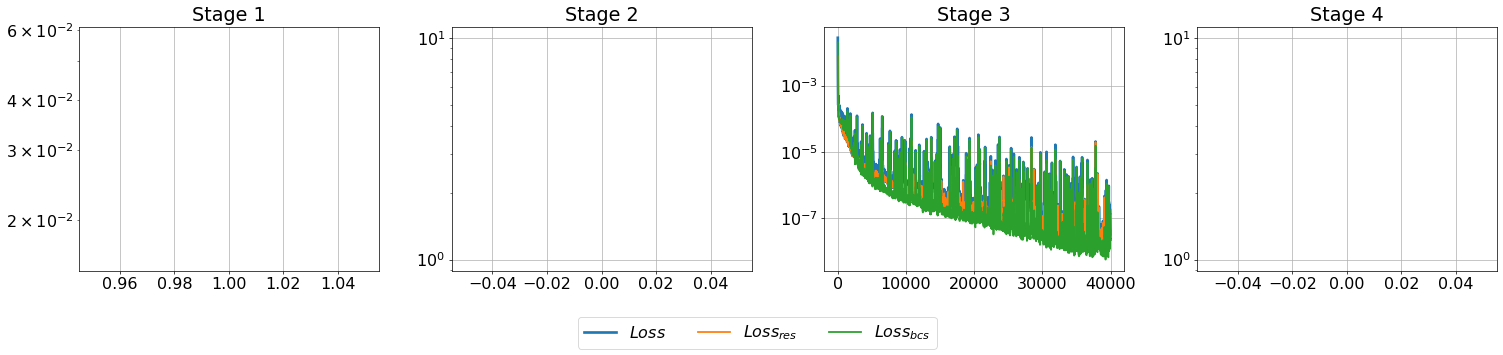

In [17]:
# loss图
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()
fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["loss"], label=r"$Loss$", linewidth=3)
    ax.plot(logger["iter"], logger["loss_res"], label=r"$Loss_{res}$", linewidth=2)
    ax.plot(logger["iter"], logger["loss_bcs"], label=r"$Loss_{bcs}$", linewidth=2)
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的loss图 (包括只经backbone和经过transformer和backbone的loss)

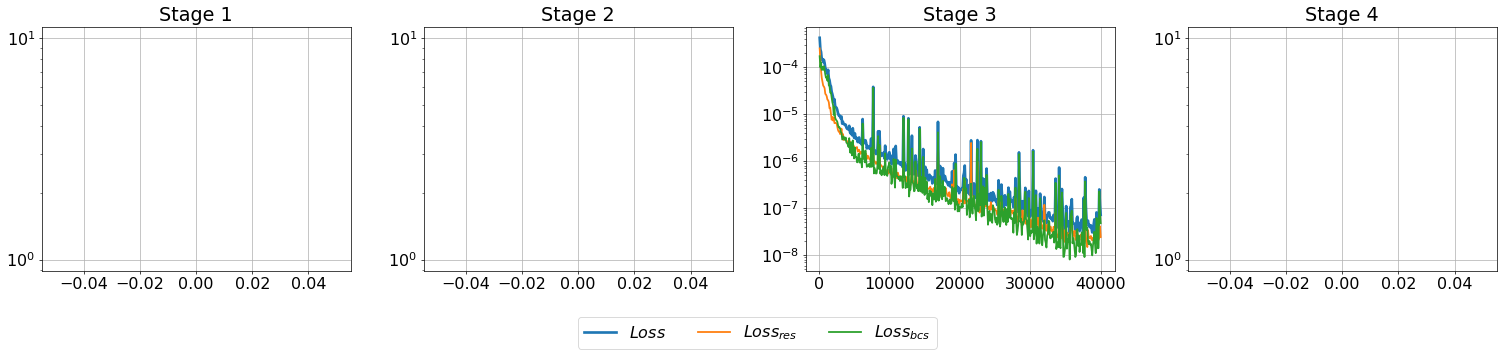

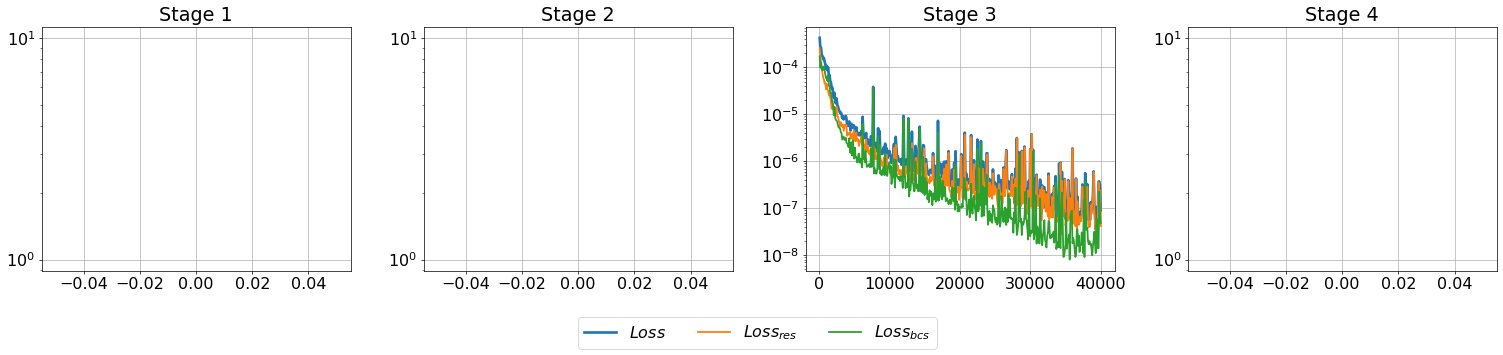

In [18]:
# valid的loss图 第一行只经过backbone 第二行经过transformer和backbone
# 因为只用backbone来valid 所以valid loss必须是对每个stage都是非增的 否则代码有误
# 由于随机采样 stage2的loss在小范围内波动属正常
# 第二行的stage2是经过transformer和backbone的 loss上升说明对抗网络是有效的
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["loss"], label=r"$Loss$", linewidth=3)
    ax.plot(logger["iter"], logger["loss_res"], label=r"$Loss_{res}$", linewidth=2)
    ax.plot(logger["iter"], logger["loss_bcs"], label=r"$Loss_{bcs}$", linewidth=2)
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
# plt.savefig('loss_valid.png', dpi=100, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["loss_transformer"], label=r"$Loss$", linewidth=3)
    ax.plot(logger["iter"], logger["loss_res_transformer"], label=r"$Loss_{res}$", linewidth=2)
    ax.plot(logger["iter"], logger["loss_bcs_transformer"], label=r"$Loss_{bcs}$", linewidth=2)
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
# plt.savefig('loss_valid_transformer.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的Relative L2 error图 (包括只经backbone和经过transformer和backbone的rl2)

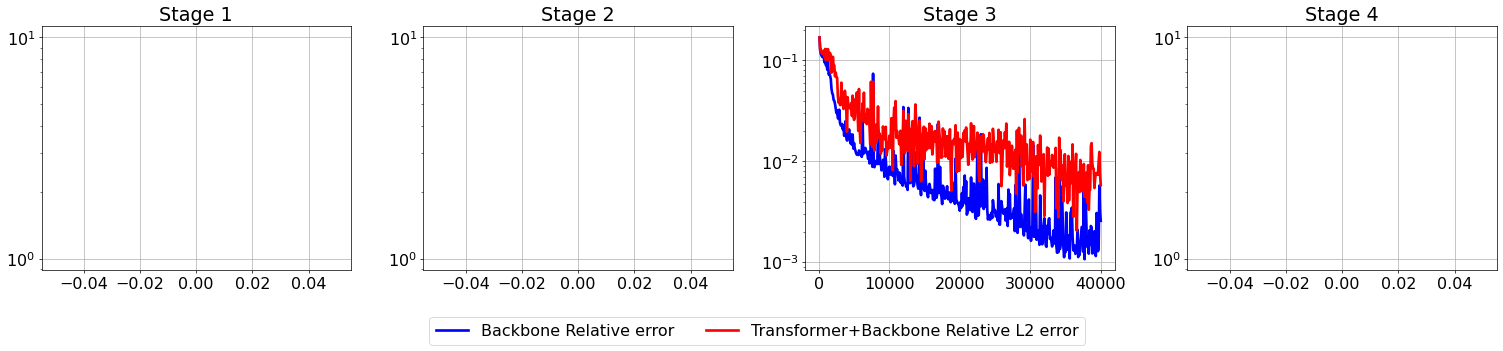

In [19]:
# valid中记录的relative l2 error记录 第一行只经过backbone 第二行经过transformer和backbone
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["error"], label=r"Backbone Relative error", color="blue", linewidth=3)
    ax.plot(logger["iter"], logger["error_transformer"], label=r"Transformer+Backbone Relative L2 error", color="red", linewidth=3)
    
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
plt.savefig('Relative_L2_error.png', dpi=100, bbox_inches='tight')
plt.show()

### Relative L2 error (仅考虑内部点）

In [20]:
# 使用最好的模型
backbone = ResNet(args.backbone_layers)
state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
backbone.load_state_dict(state_dict['state_dict'])
backbone.eval()
print("Stage:\t", state_dict['stage'])
print("Iter:\t", state_dict['iter'] + 1)
print("Loss:\t", "{:.2e}".format(state_dict['best_loss']))

Stage:	 3
Iter:	 37700
Loss:	 2.67e-08


In [21]:
def exact_sol(X):
    # 解析解
    u_star = X.mean(axis=1, keepdims=True)
    u_star = u_star**2 + np.sin(u_star)
    return u_star

# 采样内部点
dataset = Dataset_PoissonHD(args.bot_top, args.dim, torch.device('cpu'))
X_res, _, _, _ = dataset.train_data(N_r=10000, N_b=0)
# 计算u_star u_pred
u_star = exact_sol(X_res)
u_pred = backbone(X_res)

u_star = u_star.detach().numpy()
u_pred = u_pred.detach().numpy()
#计算L2相对误差
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
with open("RL2.txt", 'w') as f:
    f.write(str(error_u))
print('Relative L2 error: {:.3e}'.format(error_u))

Relative L2 error: 1.417e-03


### 可视化内部(x1, x2, 0, ..., 0)

In [22]:
n = 101
dim = args.dim
# 取前两维
x1 = np.linspace(-1, 1, n)
x2 = np.linspace(-1, 1, n)
x1, x2 = np.meshgrid(x1, x2)
# x3, ..., x50 = 0
x12 = np.zeros((n*n, dim))
x12[:, [0]] = x1.reshape(-1, 1)
x12[:, [1]] = x2.reshape(-1, 1)
x12 = torch.from_numpy(x12).float()
# 解析解和预测解
u12_star = exact_sol(x12)
u12_pred = backbone(x12)

u12_star = u12_star.detach().numpy()
u12_pred = u12_pred.detach().numpy()

u12_star = u12_star.reshape(x1.shape)
u12_pred = u12_pred.reshape(x1.shape)

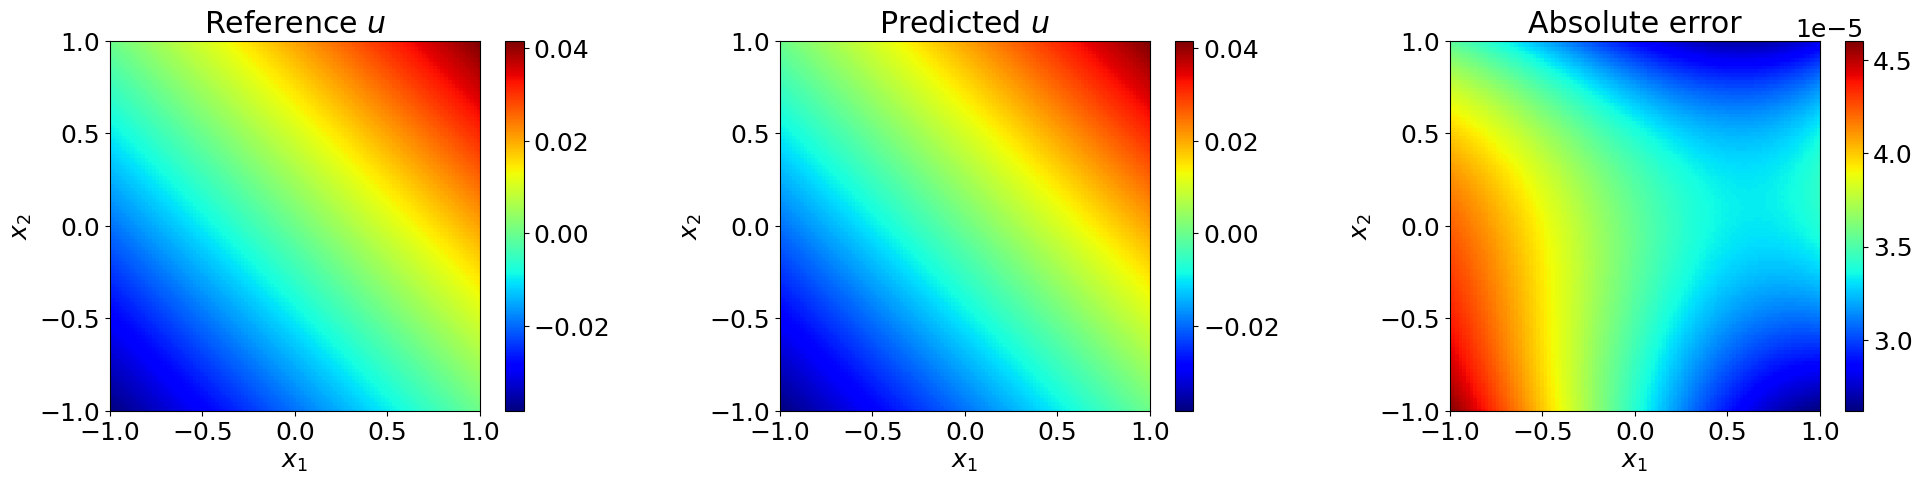

In [23]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].pcolor(x1, x2, u12_star, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u$')
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xticks(np.arange(-1, 1.1, 0.5))
axes[0].set_yticks(np.arange(-1, 1.1, 0.5))
axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].pcolor(x1, x2, u12_pred, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u$')
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xticks(np.arange(-1, 1.1, 0.5))
axes[1].set_yticks(np.arange(-1, 1.1, 0.5))
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].pcolor(x1, x2, np.abs(u12_star - u12_pred), cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_xlim([-1, 1])
axes[2].set_ylim([-1, 1])
axes[2].set_xticks(np.arange(-1, 1.1, 0.5))
axes[2].set_yticks(np.arange(-1, 1.1, 0.5))
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('HeatHD_result.png', dpi=100, bbox_inches='tight')
plt.show()

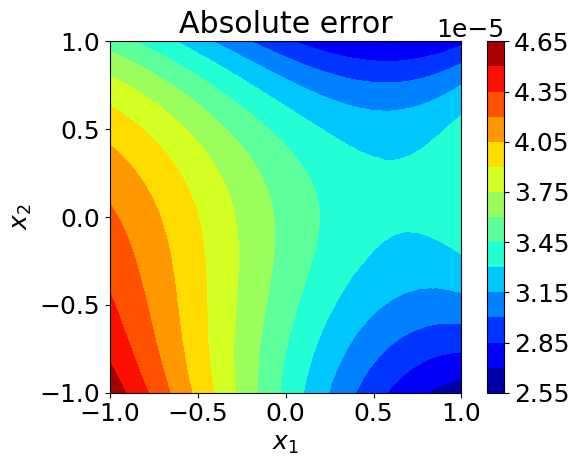

In [24]:
fig, ax = plt.subplots(figsize=(6.5, 5), dpi=100)
plot = ax.contourf(x1, x2, np.abs(u12_star - u12_pred), levels=16, cmap='jet')

cbar = fig.colorbar(plot)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_title('Absolute error')
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('./Absolute_error', dpi=100)
plt.show()

## Transformer变换可视化

In [25]:
# loss_res
trainer.device = torch.device('cpu')
trainer.backbone = trainer.backbone.cpu()

f_res = trainer.dataset.func_res(x12)
f_res_pred = trainer.net_r(x12)
loss_res = (f_res - f_res_pred) ** 2

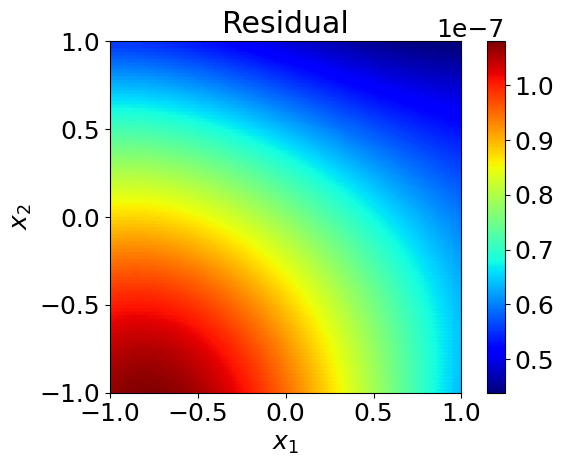

In [26]:
fig = plt.figure(figsize=(6.5, 5))
ax = fig.subplots()

cax = ax.scatter(x12.detach().numpy()[:, 0], x12.detach().numpy()[:, 1], 
                 c=loss_res.detach().cpu().numpy(), 
#                  vmin=0, vmax=5e-5,
                 cmap="jet", s=80)
fig.colorbar(cax)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title(r'Residual')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xticks(np.arange(-1, 1.1, 0.5))
ax.set_yticks(np.arange(-1, 1.1, 0.5))
ax.set_aspect(1./axes[0].get_data_ratio())

plt.tight_layout()
plt.show()

In [27]:
# 重新取点
n = 21
dim = args.dim
# 取前两维
xx1 = np.linspace(-1, 1, n)
xx2 = np.linspace(-1, 1, n)
xx1, xx2 = np.meshgrid(xx1, xx2)
# x3, ..., x50 = 0
xx12 = np.zeros((n*n, dim))
xx12[:, [0]] = xx1.reshape(-1, 1)
xx12[:, [1]] = xx2.reshape(-1, 1)
xx12 = torch.from_numpy(xx12).float()

In [28]:
# 变换后的点
# model = MLP(args.subnet_layers)  # 保存的loss最低时的transformer
# transformer = TransformerNet(model, args.bot_top)

# state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
# transformer.load_state_dict(state_dict['state_dict_transformer'])
# transformer.eval()

# xx12_ = transformer(xx12)

trainer.transformer = trainer.transformer.cpu()  # 训练最后的transformer
f_xx12 = dataset.func_res(xx12)
k = trainer.update_k(xx12, f_xx12)
xx12_ = trainer.net_transformer(xx12, k)

(array([26., 46., 55., 66., 54., 48., 41., 36., 35., 34.]),
 array([0.06836448, 0.07836448, 0.08836448, 0.09836448, 0.10836448,
        0.11836448, 0.12836447, 0.13836448, 0.14836448, 0.15836447,
        0.16836448]),
 <BarContainer object of 10 artists>)

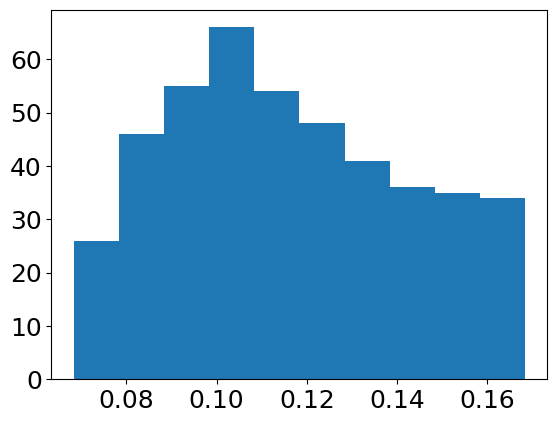

In [29]:
plt.hist(k.detach().cpu().numpy().flatten())

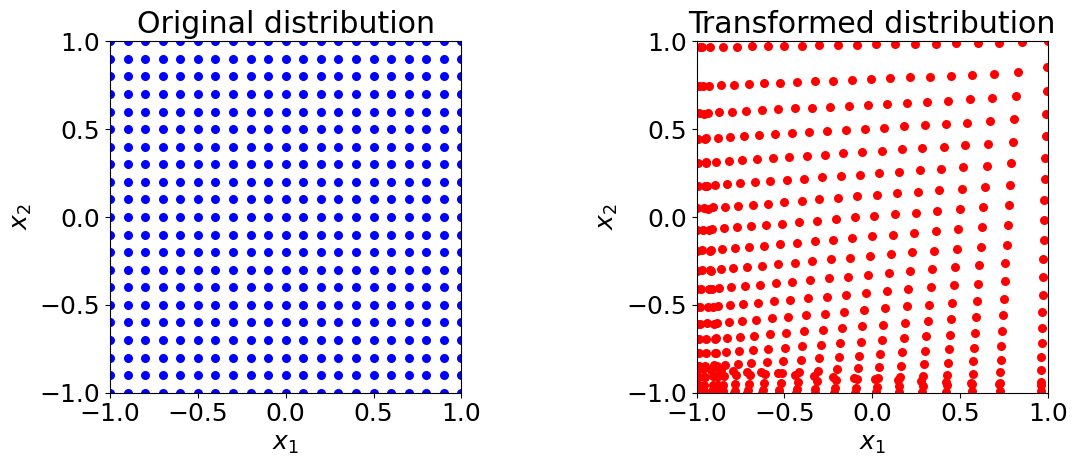

In [30]:
fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(1, 2)

axes[0].scatter(xx12.detach().numpy()[:, 0], xx12.detach().numpy()[:, 1], s=30, color='b')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Original distribution')
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xticks(np.arange(-1, 1.1, 0.5))
axes[0].set_yticks(np.arange(-1, 1.1, 0.5))
axes[0].set_aspect(1./axes[0].get_data_ratio())

axes[1].scatter(xx12_.detach().numpy()[:, 0], xx12_.detach().numpy()[:, 1], s=30, color='r')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title('Transformed distribution')
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xticks(np.arange(-1, 1.1, 0.5))
axes[1].set_yticks(np.arange(-1, 1.1, 0.5))
axes[1].set_aspect(1./axes[1].get_data_ratio())

plt.tight_layout()
plt.show()